# Corrector Coil

Here we will make a corrector coil as a 3D Cartesian grid and track.



In [1]:
import numpy as np
from math import pi
from scipy.constants import c
import os

from pmd_beamphysics.fields.corrector_modeling import make_dipole_corrector_fieldmesh

from impact import Impact

In [2]:
ROOT = "../templates/corrector_coil"
assert os.path.exists(ROOT)

# Create FieldMesh

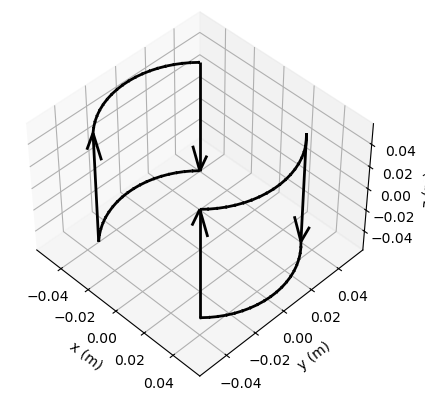

In [3]:
R = 2 * 2.54e-2  # 2" radius [m]
L = 0.1  # Length along z [m]
theta = np.pi / 2  # Opening angle [rad]
current = 100  # Current [Amp]

FM = make_dipole_corrector_fieldmesh(
    current=current,
    xmin=-R,
    xmax=R,
    nx=11,
    ymin=-R,
    ymax=R,
    ny=13,
    zmin=-5 * L / 2,
    zmax=5 * L / 2,
    nz=31,
    mode="saddle",
    R=R,
    L=L,
    theta=theta,
    npts=20,
    plot_wire=True,
    tilt=pi / 2,
)

FM.zmin = 0

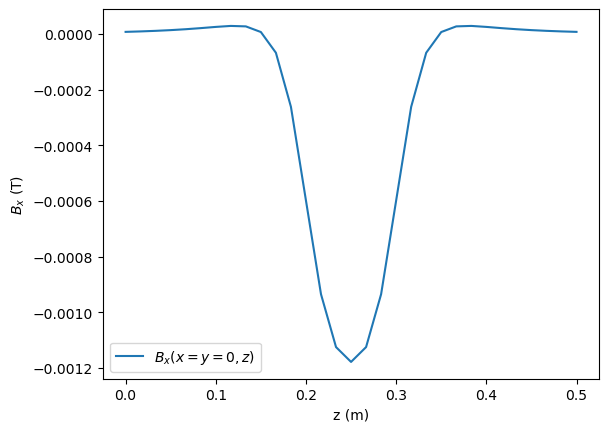

In [4]:
FM.plot_onaxis("Bx")

# Prepare for Impact-T

In [5]:
T7file = os.path.join(ROOT, "1T1.T7")
FM.write_impact_emfield_cartesian(T7file)

In [6]:
!head {outfile}

head: cannot open '{outfile}' for reading: No such file or directory


In [7]:
!ls -ahl {T7file}

-rw-r--r-- 1 runner docker 501K Nov 22 00:54 ../templates/corrector_coil/1T1.T7


# Run Impact-T

In [8]:
I = Impact(os.path.join(ROOT, "ImpactT.in"))
I.ele["COIL"]  # ['rf_field_scale'] = 1

{'description': 'name:COIL',
 'original': '0.5 0 0 111 0.0 1 0.0 0 1 0.02 0.0 0.0 0.0 0.0 0.0 /!name:COIL',
 'L': 0.5,
 'type': 'emfield_cartesian',
 'zedge': 0.0,
 'rf_field_scale': 1.0,
 'rf_frequency': 0.0,
 'theta0_deg': 0.0,
 'filename': '1T1.T7',
 'radius': 0.02,
 's': 0.5,
 'name': 'COIL'}

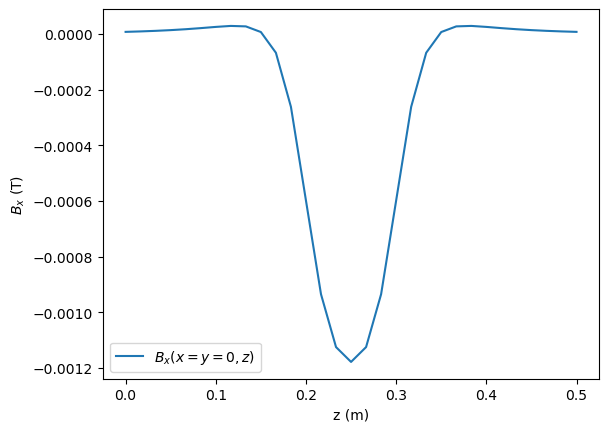

In [9]:
FM = I.fieldmaps["1T1.T7"]["field"]
FM.plot_onaxis("Bx")

In [10]:
I.ele["COIL"]

{'description': 'name:COIL',
 'original': '0.5 0 0 111 0.0 1 0.0 0 1 0.02 0.0 0.0 0.0 0.0 0.0 /!name:COIL',
 'L': 0.5,
 'type': 'emfield_cartesian',
 'zedge': 0.0,
 'rf_field_scale': 1.0,
 'rf_frequency': 0.0,
 'theta0_deg': 0.0,
 'filename': '1T1.T7',
 'radius': 0.02,
 's': 0.5,
 'name': 'COIL'}

In [11]:
I.fieldmaps["1T1.T7"]

{'info': {'format': 'emfield_cartesian_fieldmesh'},
 'field': <FieldMesh with rectangular geometry and (11, 13, 31) shape at 0x7f1c009522a0>}

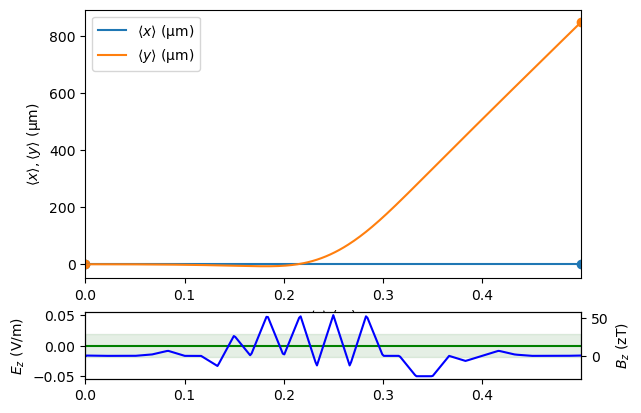

In [12]:
pz0 = 10e6

I.track1(pz0=pz0)

I.plot(["mean_x", "mean_y"])

# Check field integral

In [13]:
z0 = FM.coord_vec("z")
Bx0 = np.real(FM.Bx[FM.shape[0] // 2, FM.shape[1] // 2, :])

BL = np.trapezoid(Bx0, z0)

BL

np.float64(-0.00011352516130577002)

In [14]:
theta0 = -BL * c / pz0

theta0

np.float64(0.003403398715270328)

In [15]:
I.track1(pz0=pz0)
theta1 = I.particles["final_particles"].py / pz0

theta1

array([0.00340263])

In [16]:
rel_diff = abs(theta1 / theta0 - 1)
rel_diff

array([0.00022678])

# Check that both are close

In [17]:
assert rel_diff < 1e-3

# Check archiving

In [18]:
archive_file = "test.h5"
I.archive(archive_file)

'test.h5'

In [19]:
I2 = Impact.from_archive(archive_file)
assert I.input == I2.input

# Cleanup

We will leave the field file in templates so that the example is complete.

In [20]:
os.remove(T7file)

In [21]:
os.remove(archive_file)